In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
from mpl_toolkits import mplot3d
import numpy as np
import math

### A linear Poisson equation
$\nabla^2 u = sin(\pi x) sin(\pi y)$ \
$0 \leq x \leq 1$ \
$0 \leq y \leq 1$

### Problem specific functions / variables

In [3]:
# partial differential equation
def f(x):
    return torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

def L(model, x):
    y = model(x.float())
    y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
    retain_graph=True,
    create_graph=True,
    allow_unused=True)[0]

    return torch.sum(y_xx, -1)

# boundary conditions
def g(x):
    return torch.zeros(x.size()[0])

def B(model, x):
    return model(x.float())[:,0]

# Quadrature

N = 20
xs = torch.linspace(0, 1, steps=N, requires_grad=True)
ys = torch.linspace(0, 1, steps=N, requires_grad=True)
x,y = torch.meshgrid(xs, ys)
w = torch.cat((torch.reshape(x, (1,-1)), torch.reshape(y,(1,-1))), 0).T

dw = []
for xy in w:
    if xy[0] == 0 or xy[1] == 0 or xy[0] == 1 or xy[1] == 1:
        dw.append(xy)
dw = torch.stack(dw)

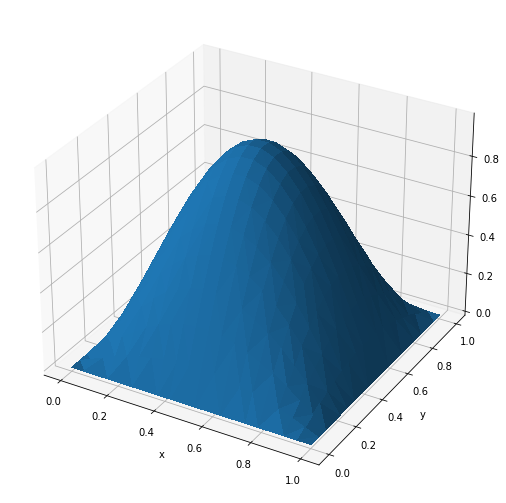

In [4]:
# Creating dataset
z = f(w)
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

xs_plt = w[:,0].detach().numpy()
ys_plt = w[:,1].detach().numpy()
zs_plt = z.detach().numpy()

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, zs_plt, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/analytical_grad2.png')

plt.show()

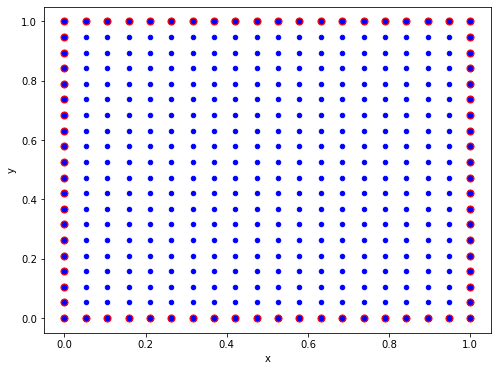

In [5]:
dxs_plt = dw[:,0].detach().numpy()
dys_plt = dw[:,1].detach().numpy()

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.scatter(dxs_plt,dys_plt, c = 'r', s = 50)
ax.scatter(xs_plt,ys_plt, c = 'b', s = 20)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/quadrature.png')

plt.show()

In [6]:
# MC point selection
def quadMC(N):
    w = torch.rand((N ** 2, 2), requires_grad=True)
    dw = torch.rand((4 * N, 1))
    fw = torch.cat((torch.ones((2 * N, 1)), torch.zeros(2 * N, 1)))
    dw = torch.cat((dw, fw), -1)
    dw[N:(3 * N), :] = torch.flip(dw[N:(3 * N), :], (1,))
    dw.requires_grad = True
    return w, dw

w_mc, dw_mc = quadMC(20)

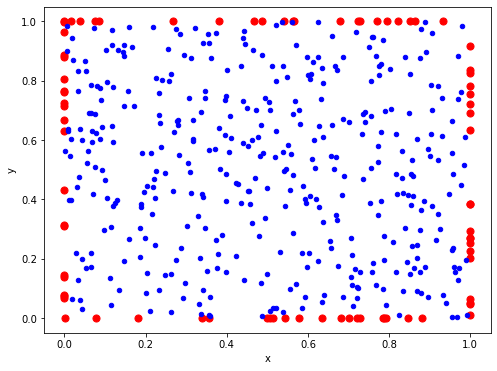

In [7]:
xs_plt_mc = w_mc[:,0].detach().numpy()
ys_plt_mc = w_mc[:,1].detach().numpy()

dxs_plt_mc = dw_mc[:,0].detach().numpy()
dys_plt_mc = dw_mc[:,1].detach().numpy()

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.scatter(dxs_plt_mc,dys_plt_mc, c = 'r', s = 50)
ax.scatter(xs_plt_mc,ys_plt_mc, c = 'b', s = 20)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/quadrature_mc.png')

plt.show()

### Loss function

In [8]:
def h(model, w_, dw_):
    df = L(model, w_) - f(w_)
    dg = B(model, dw_) - g(dw_)
    df_loss = torch.sum(torch.square(df)) / (N ** 2)
    dg_loss = torch.sum(torch.square(dg)) / N
    loss = df_loss + dg_loss
    return loss, df_loss, dg_loss

### Neural Network

In [9]:
class MyFunction(nn.Module):
    def __init__(self,input_size=2,output_size=1):
        super(MyFunction, self).__init__()
        self.linear1 = nn.Linear(input_size,5)
        self.linear2 = nn.Linear(5,5)
        self.linear3 = nn.Linear(5,output_size)

    def forward(self,x):
        z = torch.sigmoid(self.linear1(x))
        z = torch.sigmoid(self.linear2(z))
        z = torch.tanh(self.linear3(z))
        return z

pdeApprox = MyFunction()

### Training loop

In [10]:
optimizer = torch.optim.Adam(pdeApprox.parameters(), lr=0.001)
losses = []
#train the neural network for 5 epochs
for epoch in range(20000):      
    #reset gradients
    optimizer.zero_grad()
        
    #calculate the loss
    loss = h(pdeApprox, w, dw)
    losses.append(np.array(torch.tensor(loss, requires_grad=False)))
    if epoch % 1000 == 0:
        print("Epoch: {e} - Loss: {l:.6f} - Loss (df): {dfl:.6f} - Loss (dg): {dgl:.6f}".format(e=epoch, l=loss[0].item(), dfl=loss[1].item(), dgl=loss[2].item()))
        
    #backpropagation
    loss[0].backward(retain_graph=True)
    
    #update the parameters
    optimizer.step()

Epoch: 0 - Loss: 0.881399 - Loss (df): 0.223690 - Loss (dg): 0.657709
Epoch: 1000 - Loss: 0.109876 - Loss (df): 0.102830 - Loss (dg): 0.007046
Epoch: 2000 - Loss: 0.077554 - Loss (df): 0.068128 - Loss (dg): 0.009425
Epoch: 3000 - Loss: 0.018924 - Loss (df): 0.018203 - Loss (dg): 0.000721
Epoch: 4000 - Loss: 0.015330 - Loss (df): 0.014399 - Loss (dg): 0.000931
Epoch: 5000 - Loss: 0.008236 - Loss (df): 0.006365 - Loss (dg): 0.001871
Epoch: 6000 - Loss: 0.006096 - Loss (df): 0.003738 - Loss (dg): 0.002358
Epoch: 7000 - Loss: 0.004532 - Loss (df): 0.002550 - Loss (dg): 0.001982
Epoch: 8000 - Loss: 0.003016 - Loss (df): 0.001522 - Loss (dg): 0.001494
Epoch: 9000 - Loss: 0.002130 - Loss (df): 0.000710 - Loss (dg): 0.001420
Epoch: 10000 - Loss: 0.001925 - Loss (df): 0.000537 - Loss (dg): 0.001389
Epoch: 11000 - Loss: 0.001804 - Loss (df): 0.000495 - Loss (dg): 0.001308
Epoch: 12000 - Loss: 0.001583 - Loss (df): 0.000445 - Loss (dg): 0.001138
Epoch: 13000 - Loss: 0.000574 - Loss (df): 0.000221

### Neural Network Approximation

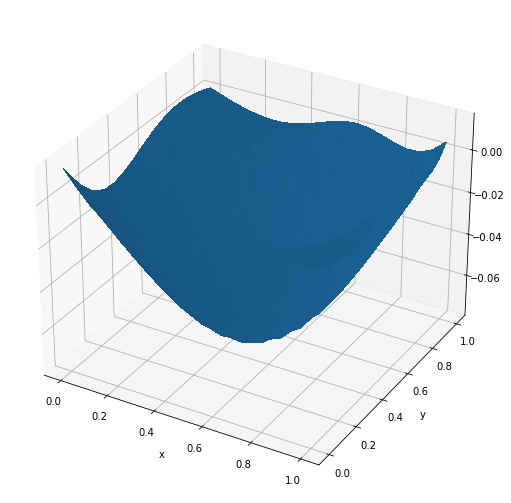

In [11]:
# Creating dataset
pred = pdeApprox(w)[:,0].detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, pred, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/pred.png')

plt.show()

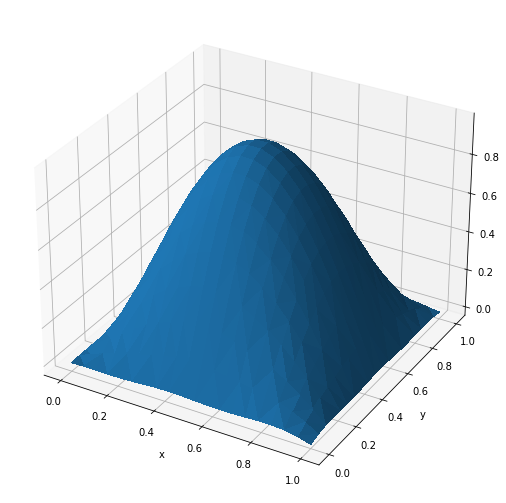

In [12]:
# Creating dataset
grad2 = L(pdeApprox, w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, grad2, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/pred_grad2.png')

plt.show()

### Training Curve

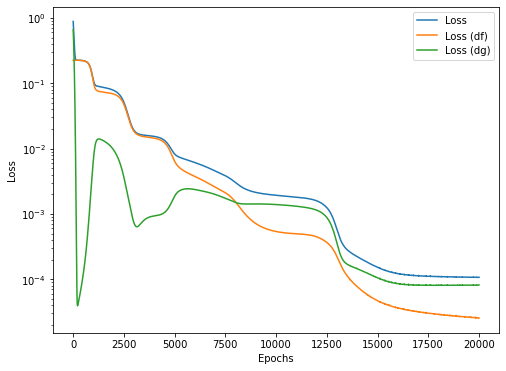

In [13]:
losses = np.array(losses)

fig = plt.figure(figsize =(8, 6))
ax = plt.axes()

ax.plot(losses[:,0], label = "Loss")
ax.plot(losses[:,1], label = "Loss (df)")
ax.plot(losses[:,2], label = "Loss (dg)")

ax.set(xlabel="Epochs", ylabel="Loss")
ax.set_yscale('log')
ax.legend()

plt.savefig('../Figures/training_curve.png')
plt.show()

### Analytical Solution

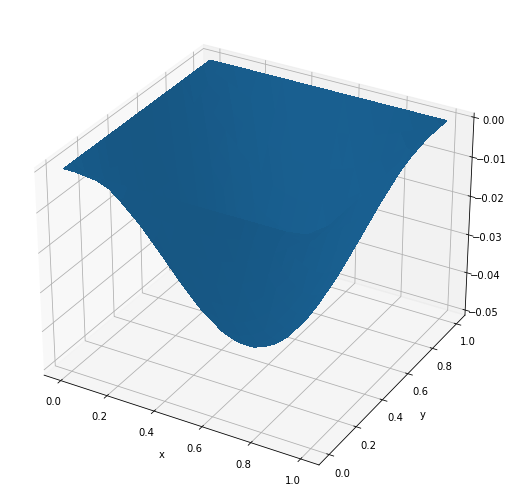

In [14]:
def analytical(x):
    return - 1 / (2 * torch.tensor(math.pi) ** 2) * torch.sin(torch.tensor(math.pi)*x[:,0]) * torch.sin(torch.tensor(math.pi)*x[:,1])

# Creating dataset
solution = analytical(w).detach().numpy()
 
# Creating figure
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

# Creating plot
surf = ax.plot_trisurf(xs_plt, ys_plt, solution, linewidth=0, antialiased=False)
ax.set(xlabel="x", ylabel="y")

plt.savefig('../Figures/analytical_solution.png')

plt.show()

### Low Precision

In [15]:
import torch
import qtorch
from qtorch import FixedPoint, FloatingPoint
from qtorch.quant import fixed_point_quantize, block_quantize, float_quantize
from qtorch.auto_low import sequential_lower

from torch.optim import Adam
from qtorch.optim import OptimLP;

/home/convery/anaconda3/envs/ml/lib/python3.9/site-packages/torch/cuda/__init__.py:106: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [16]:
forward_num = FixedPoint(wl=4, fl=2)
backward_num = FloatingPoint(exp=5, man=2)
pdeApproxLP = sequential_lower(MyFunction(), layer_types=['linear'],
                            forward_number=forward_num, backward_number=backward_num)

In [45]:
pdeApproxLP

MyFunction(
  (linear1): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Quantizer()
  )
  (linear2): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Quantizer()
  )
  (linear3): Sequential(
    (0): Linear(in_features=5, out_features=1, bias=True)
    (1): Quantizer()
  )
)

In [17]:
optimizer = Adam(pdeApproxLP.parameters(), lr=0.001) # use your favorite optimizer
# define custom quantization functions for different numbers
weight_quant = lambda x : float_quantize(x, exp=5, man=2, rounding="nearest")
gradient_quant = lambda x : float_quantize(x, exp=5, man=2, rounding="nearest")
momentum_quant = lambda x : float_quantize(x, exp=6, man=9, rounding="nearest")
# turn your optimizer into a low precision optimizer
optimizer = OptimLP(optimizer, 
                    weight_quant=weight_quant, 
                    grad_quant=gradient_quant, 
                    momentum_quant=momentum_quant)

In [37]:
losses = []
#train the neural network for 5 epochs
for epoch in range(20000):
    #reset gradients
    optimizer.zero_grad()
    
    #calculate the loss
    loss = h(pdeApproxLP, w, dw)
    losses.append(np.array(torch.tensor(loss, requires_grad=False)))
    if epoch % 1000 == 0:
        print("Epoch: {e} - Loss: {l:.6f} - Loss (df): {dfl:.6f} - Loss (dg): {dgl:.6f}".format(e=epoch, l=loss[0].item(), dfl=loss[1].item(), dgl=loss[2].item()))
    
    #backpropagation
    loss[0].backward(retain_graph=True)
    
    #update the parameters
    optimizer.step()

TypeError: sum() received an invalid combination of arguments - got (NoneType, int), but expected one of:
 * (Tensor input, *, torch.dtype dtype)
 * (Tensor input, tuple of ints dim, bool keepdim, *, torch.dtype dtype, Tensor out)
 * (Tensor input, tuple of names dim, bool keepdim, *, torch.dtype dtype, Tensor out)


In [47]:
x = w
x = fixed_point_quantize(x, 4, 2)
x.requires_grad=True
x.retain_graph=True
x.create_graph=True
x.allow_unused=True

y = pdeApproxLP(x.float())
y_x = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
retain_graph=True,
create_graph=True,
allow_unused=True)[0]

y_xx = torch.autograd.grad(y_x, x, grad_outputs=torch.ones_like(y_x),
retain_graph=True,
create_graph=True,
allow_unused=True)[0]

print(type(y_x))
print(y_xx)

<class 'torch.Tensor'>
None
